<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/MobNetV3_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

2025-03-10 18:29:13.224997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 18:29:13.241001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 18:29:13.245701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 18:29:13.261927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1) DATA PRE-PROCESSING

a) Load in labels + image file paths

b) combine them into one dataframe

c) EDA - spotted and removed erroneous label (speed = 1.42...)

- `cleaned_df` is the cleaned df with a) b) c) completed

d) convert images to numerical RGB feature maps - ML algorithms only understand numerical data

e) Splitting data into training and validation sets

f) data augmentation applied to training set

### 1a) load in labels + image file paths

In [ ]:
# labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [ ]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data' # bens hpc file path
# image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [ ]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [ ]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


### 1b) Combine labels and image file paths into one dataframe

In [ ]:
merged_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
merged_df['speed'] = merged_df['speed'].round(6) # to get rid of floating point errors

In [ ]:
merged_df.head()

,angle,speed,image_file_paths
image_id,,,
1,0.4375,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,0.8125,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,0.4375,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,0.6250,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,0.5000,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


In [ ]:
merged_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3139.png
3140,0.875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3143.png


The above cell shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

### 1c) EDA

In [ ]:
merged_df.value_counts('angle')

angle
0.7500    2123
0.5000    2046
0.6875    2007
0.6250    1963
0.5625    1609
0.4375    1467
0.8125    1147
0.3750     428
0.8750     301
0.3125     213
0.2500     104
0.1250      99
0.1875      98
0.9375      65
0.0000      60
1.0000      35
0.0625      28
Name: count, dtype: int64

note: imbalance datset

identifying the row with the erroneous speed value

In [ ]:
merged_df[merged_df['speed'] == 1.428571]

,angle,speed,image_file_paths
image_id,,,
3884,0.4375,1.428571,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3884.png


we want to remove this row

In [ ]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]
cleaned_df.loc[3882:3886]

,angle,speed,image_file_paths
image_id,,,
3882,0.5625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3882.png
3883,0.3750,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3883.png
3885,0.0000,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3885.png
3886,0.7500,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3886.png


### 1d) convert images to numerical RGB feature maps

In [ ]:
def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["angle"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

lets check and see if what we have done works

In [ ]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)
    print(labels)

(32, 224, 224, 3) (32,)
tf.Tensor(
[0.6875 0.4375 0.5    0.5625 0.4375 0.4375 0.6875 0.75   0.75   0.4375
 0.8125 0.6875 0.75   0.5    0.5625 0.4375 0.6875 0.5    0.5625 0.625
 0.4375 0.6875 0.5625 0.5625 0.75   0.5    0.625  0.75   0.5    0.8125
 0.6875 0.75  ], shape=(32,), dtype=float64)


### 1e) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [ ]:
# 80-20 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

In [ ]:
print(f"Train size: {train_size}, validation size: {dataset_size - train_size}")

Train size: 344, validation size: 87


In [ ]:
validation_dataset

<_SkipDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### 1f) Data augmentation applied to training set

Flipping or rotating the image will render the angle labels incorrect so none of that was applied to the images for this regression task

- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment


In [ ]:
#only performing augmentation on training data as want validation/test data to reflect kaggle test set
seed = (6,9)
train_dataset = train_dataset.map(
      lambda image, label: (tf.image.stateless_random_brightness(image, 0.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_contrast(image,0.8,1.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_hue(image,0.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_saturation(image,0.8,1.2,seed),label)
).take(5
)

checking to see if whats been done was successful or needs debugging

image shape:  (224, 224, 3)
label: 0.5


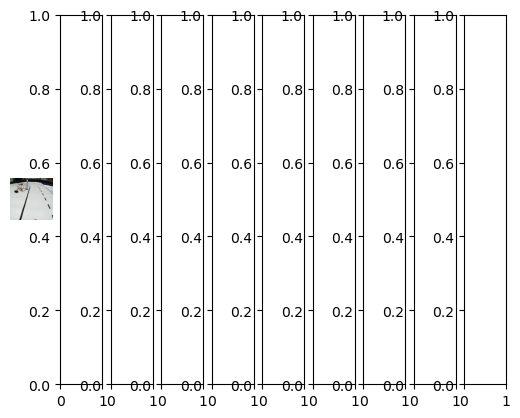

image shape:  (224, 224, 3)
label: 0.625
image shape:  (224, 224, 3)
label: 0.75
image shape:  (224, 224, 3)
label: 0.75
image shape:  (224, 224, 3)
label: 0.5625
image shape:  (224, 224, 3)
label: 0.625
image shape:  (224, 224, 3)
label: 0.8125
image shape:  (224, 224, 3)
label: 0.75
image shape:  (224, 224, 3)
label: 0.5
image shape:  (224, 224, 3)
label: 0.5


In [ ]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
        plt.show()

# 2) Model Building - MobileNetV3Large Transfer Learning

a) Set up model architecture

b) define training step

c) training the model on the training set

d) fine-tuning

### 2a) Set up model architecture

- MobileNetV2 to learn lower level features
- global average pooling layer
- drop out layer
- dense layer with sigmoid activation

In [ ]:
dropoutrate = 0.2
num_classes = 1 # we're only predicting the prob of the positive class with a sigmoid
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,285,633 (12.53 MB)

 Trainable params: 289,281 (1.10 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

### 2b) Define training step

- adam optimiser
- binary cross entropy loss function

In [ ]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

@tf.function
def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        Y = tf.cast(Y, tf.float32)
        current_loss = tf.reduce_mean(tf.losses.MeanSquaredError()( Y,  pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_MSE = tf.reduce_mean(tf.square(Y-pred))
    return(current_loss, current_MSE)

### 2c) Training the model on the training set

In [ ]:
niter = 200

tloss = []
tMSE = []
vloss = []
vMSE = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_MSEs = []
    for image_batch, label_batch in train_dataset:
        loss, MSE = train_step(model, image_batch, label_batch)
        batch_losses.append(loss)
        batch_MSEs.append(MSE)

    # Calculate average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses)
    avg_MSE = tf.reduce_mean(batch_MSEs)
    tloss.append(avg_loss)
    tMSE.append(avg_MSE)

    # Validation
    val_batch_losses = []
    val_batch_MSEs = []
    for image_batch, label_batch in validation_dataset:
        val_loss, val_MSE = train_step(model, image_batch, label_batch)
        val_batch_losses.append(val_loss)
        val_batch_MSEs.append(val_MSE)

    # Calculate average validation metrics
    avg_val_loss = tf.reduce_mean(val_batch_losses)
    avg_val_MSE = tf.reduce_mean(val_batch_MSEs)
    vloss.append(avg_val_loss)
    vMSE.append(avg_val_MSE)

    # Print metrics every 10 iterations
    if it % 10 == 0:  # Check if (it + 1) is divisible by 10
        tf.print('iter: {}, train_loss: {:.3f}, train_MSE: {:.3f}, val_loss: {:.3f}, val_MSE: {:.3f}'.format(
            it, avg_loss, avg_MSE, avg_val_loss, avg_val_MSE))

iter: 0, train_loss: 0.178, train_MSE: 0.179, val_loss: 0.017, val_MSE: 0.038
iter: 10, train_loss: 0.010, train_MSE: 0.041, val_loss: 0.010, val_MSE: 0.040
iter: 20, train_loss: 0.009, train_MSE: 0.035, val_loss: 0.009, val_MSE: 0.038
iter: 30, train_loss: 0.007, train_MSE: 0.044, val_loss: 0.007, val_MSE: 0.039
iter: 40, train_loss: 0.007, train_MSE: 0.042, val_loss: 0.007, val_MSE: 0.041
iter: 50, train_loss: 0.008, train_MSE: 0.042, val_loss: 0.007, val_MSE: 0.039


2025-03-10 19:41:14.271478: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 60, train_loss: 0.007, train_MSE: 0.035, val_loss: 0.007, val_MSE: 0.042
iter: 70, train_loss: 0.010, train_MSE: 0.037, val_loss: 0.007, val_MSE: 0.040
iter: 80, train_loss: 0.008, train_MSE: 0.039, val_loss: 0.007, val_MSE: 0.041
iter: 90, train_loss: 0.008, train_MSE: 0.046, val_loss: 0.007, val_MSE: 0.040
iter: 100, train_loss: 0.006, train_MSE: 0.037, val_loss: 0.007, val_MSE: 0.040
iter: 110, train_loss: 0.006, train_MSE: 0.045, val_loss: 0.006, val_MSE: 0.041
iter: 120, train_loss: 0.011, train_MSE: 0.046, val_loss: 0.006, val_MSE: 0.040
iter: 130, train_loss: 0.010, train_MSE: 0.046, val_loss: 0.006, val_MSE: 0.042
iter: 140, train_loss: 0.007, train_MSE: 0.052, val_loss: 0.006, val_MSE: 0.043
iter: 150, train_loss: 0.009, train_MSE: 0.044, val_loss: 0.006, val_MSE: 0.042
iter: 160, train_loss: 0.005, train_MSE: 0.036, val_loss: 0.007, val_MSE: 0.043
iter: 170, train_loss: 0.005, train_MSE: 0.043, val_loss: 0.006, val_MSE: 0.040
iter: 180, train_loss: 0.006, train_MSE: 0.0

In [ ]:
model.save_weights('/home/apyba3/car_frozen_regression.weights.h5')

In [ ]:
tf.keras.backend.clear_session() #Clear keras session

### 2d) fine-tuning

rebuild model after clearing keras session

In [ ]:
dropoutrate = 0.2
num_classes = 1 # we're only predicting the prob of the positive class with a sigmoid
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.build()

mbnet.trainable = True # UNFREEZE mbnet layers

model.summary() # print the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,285,633 (12.53 MB)

 Trainable params: 3,261,233 (12.44 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [ ]:
model.load_weights('/home/apyba3/car_frozen_regression.weights.h5')

Set up fine-tuning training

In [ ]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

@tf.function
def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        Y = tf.cast(Y, tf.float32)
        current_loss = tf.reduce_mean(tf.losses.MeanSquaredError()( Y,  pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_MSE = tf.reduce_mean(tf.square(Y-pred))
    return(current_loss, current_MSE)

In [ ]:
niter = 200

tloss = []
tMSE = []
vloss = []
vMSE = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_MSEs = []
    for image_batch, label_batch in train_dataset:
        loss, MSE = train_step(model, image_batch, label_batch)
        batch_losses.append(loss)
        batch_MSEs.append(MSE)

    # Calculate average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses)
    avg_MSE = tf.reduce_mean(batch_MSEs)
    tloss.append(avg_loss)
    tMSE.append(avg_MSE)

    # Validation
    val_batch_losses = []
    val_batch_MSEs = []
    for image_batch, label_batch in validation_dataset:
        val_loss, val_MSE = train_step(model, image_batch, label_batch)
        val_batch_losses.append(val_loss)
        val_batch_MSEs.append(val_MSE)

    # Calculate average validation metrics
    avg_val_loss = tf.reduce_mean(val_batch_losses)
    avg_val_MSE = tf.reduce_mean(val_batch_MSEs)
    vloss.append(avg_val_loss)
    vMSE.append(avg_val_MSE)

    # Print metrics every 10 iterations
    if it % 10 == 0:  # Check if (it + 1) is divisible by 10
        tf.print('iter: {}, train_loss: {:.3f}, train_MSE: {:.3f}, val_loss: {:.3f}, val_MSE: {:.3f}'.format(
            it, avg_loss, avg_MSE, avg_val_loss, avg_val_MSE))

iter: 0, train_loss: 875230720.000, train_MSE: 875232256.000, val_loss: 769831.250, val_MSE: 769831.250
iter: 10, train_loss: 0.147, train_MSE: 0.160, val_loss: 0.122, val_MSE: 0.133
iter: 20, train_loss: 0.252, train_MSE: 0.268, val_loss: 0.121, val_MSE: 0.134
iter: 30, train_loss: 0.020, train_MSE: 0.039, val_loss: 0.127, val_MSE: 0.143
iter: 40, train_loss: 0.113, train_MSE: 0.113, val_loss: 0.102, val_MSE: 0.102
iter: 50, train_loss: 0.102, train_MSE: 0.102, val_loss: 0.101, val_MSE: 0.101
iter: 60, train_loss: 0.100, train_MSE: 0.100, val_loss: 0.103, val_MSE: 0.103
iter: 70, train_loss: 0.122, train_MSE: 0.122, val_loss: 0.103, val_MSE: 0.103
iter: 80, train_loss: 0.105, train_MSE: 0.105, val_loss: 0.103, val_MSE: 0.103
iter: 90, train_loss: 0.107, train_MSE: 0.107, val_loss: 0.103, val_MSE: 0.103
iter: 100, train_loss: 0.106, train_MSE: 0.106, val_loss: 0.101, val_MSE: 0.101
iter: 110, train_loss: 0.106, train_MSE: 0.106, val_loss: 0.101, val_MSE: 0.101
iter: 120, train_loss: 0.

In [ ]:
model.save_weights('/home/apyba3/car_unfrozen_regression.weights.h5')

# 3) Test-Set Predictions

a) load in test data

b) convert test images to numerical RGB feature maps

c) generate predictions on the test set

d) correctly format the predictions into a pandas dataframe

e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

### 3a) load in test data

In [ ]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/5.png


### 3b) convert test images to numerical RGB feature maps

In [ ]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 3c) generate predictions on test set

In [ ]:
predictions = model.predict(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


### 3d) correctly format the predictions into a pandas dataframe

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['angle'])

In [ ]:
predictions_df.head()

,angle
0,0.35509
1,0.35509
2,0.35509
3,0.35509
4,0.35509


In [ ]:
predictions_df['angle'].value_counts()

angle
0.35509    1020
Name: count, dtype: int64

sigmoid output is between [0,1]

In [ ]:
predictions_df[predictions_df['speed'] > 0.5] = 1
predictions_df[predictions_df['speed'] < 0.5] = 0

kaggle expects integers for the speed column

In [ ]:
predictions_df['speed'] = predictions_df['speed'].astype(int)

In [ ]:
predictions_df.head()

,speed
0,0
1,1
2,1
3,1
4,1


In [ ]:
predictions_df['speed'].value_counts()

speed
1    708
0    312
Name: count, dtype: int64

### 3e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

In [ ]:
predictions_df.to_csv('/home/apyba3/mbnetv3_speedclassification_predictions.csv')